### Load libraries, functions, palette, theme, etc.

In [1]:
# load libraries
%run libraries.ipynb

In [2]:
# load functions
%run functions_load.ipynb

In [3]:
# start stopwatch
start = stopwatch_start()

In [4]:
dir_current = '03-base-model'

In [5]:
dir_save_files = 'files/'

In [6]:
dir_load_files = 'files/'

In [7]:
dir_save_img = 'docs/img/'

In [8]:
session_name = dir_current

# Section III. Base Model

## Load Saved Section if exists

## Load Data

##### Dictionaries

In [9]:
datasets = loadit('datasets', dir=dir_load_files)

In [10]:
variables = loadit('variables', dir=dir_load_files, create_empty_dict=True)

In [11]:
cv = loadit('cv', dir=dir_load_files, create_empty_dict=True)

##### Datasets

In [12]:
train = extract_variable('train_preprocessed', datasets)

In [13]:
valid = extract_variable('valid_preprocessed', datasets)

In [14]:
test = extract_variable('test_preprocessed', datasets)

Variable test_preprocessed not found


##### CV results

In [15]:
cv0 = extract_variable('cv0', cv)

In [16]:
cv1 = extract_variable('cv1', cv)

In [17]:
cv2 = extract_variable('cv2', cv)

In [18]:
cv3 = extract_variable('cv3', cv)

## Features 

In [19]:
target = 'target'

In [20]:
features = ['is_Friday', 'is_Sunday', 'is_31', 'target_previous_month']

## Naive Models

### First Naive Model

##### Predictions

In [21]:
y_pred_naive_first = valid[target].shift(1)[1:].copy()

In [22]:
y_true_naive_first = valid[target][1:].copy()

##### R-squared

In [23]:
round(r2_score(y_true_naive_first, y_pred_naive_first), 3)

0.99

##### MAE

In [24]:
math.ceil(mean_absolute_error(y_true_naive_first, y_pred_naive_first))

468

##### RMSE

In [25]:
math.ceil(root_mean_squared_error(y_true_naive_first, y_pred_naive_first))

697

##### MAPE

In [26]:
round(mean_absolute_percentage_error(y_true_naive_first, y_pred_naive_first) * 100, 2)

1.33

### Second Naive Model

##### Predictions

In [27]:
y_pred_naive_second = valid['target_previous_month'].copy()

In [28]:
y_true_naive_second = valid[target].copy()

##### R-squared

In [29]:
round(r2_score(y_true_naive_second, y_pred_naive_second), 3)

0.746

##### MAE

In [30]:
math.ceil(mean_absolute_error(y_true_naive_second, y_pred_naive_second))

2763

##### RMSE

In [31]:
math.ceil(root_mean_squared_error(y_true_naive_second, y_pred_naive_second))

3558

##### MAPE

In [32]:
round(mean_absolute_percentage_error(y_true_naive_second, y_pred_naive_second) * 100, 2)

7.68

## Stationarity

p< 0.05: Enough evidence to say, that process is stationarity

In [33]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train[target])

(-28.686047970170506,
 0.0,
 47,
 30480,
 {'1%': -3.4305645620343594,
  '5%': -2.8616348306743395,
  '10%': -2.566820475464527},
 460471.5647015386)

In [34]:
train['month'].unique()

array([1, 2, 3, 4, 5, 6, 7], dtype=int32)

In [35]:
for i in train['month'].unique():
    df_test_pvalue = sm.tsa.stattools.adfuller(train.loc[train['month']==i, target])[1]
    print('{} data stationarity: {}'.format(months_list[i-1], df_test_pvalue < 0.05))
    print(f'p-value: {df_test_pvalue}')

January data stationarity: True
p-value: 1.0644033759839667e-22
February data stationarity: True
p-value: 3.732657699349194e-20
March data stationarity: True
p-value: 7.432116387741869e-24
April data stationarity: True
p-value: 1.7428395333340719e-23
May data stationarity: True
p-value: 2.955844723407367e-22
June data stationarity: True
p-value: 4.44900636796093e-19
July data stationarity: True
p-value: 8.442519583711138e-20


## Autocorrelation

### Datasets

Train: July data;  
Validation: August data.

In [36]:
y = train.loc['2017-03', target].copy()

In [37]:
y

2017-03-01 00:00:00    29069.61702
2017-03-01 00:10:00    28579.40426
2017-03-01 00:20:00    27844.08511
2017-03-01 00:30:00    27237.44681
2017-03-01 00:40:00    26882.04255
                          ...     
2017-03-31 23:10:00    33052.59574
2017-03-31 23:20:00    32292.76596
2017-03-31 23:30:00    31042.72340
2017-03-31 23:40:00    30025.53191
2017-03-31 23:50:00    29339.23404
Freq: 10min, Name: target, Length: 4464, dtype: float64

#### ACF - 40 period

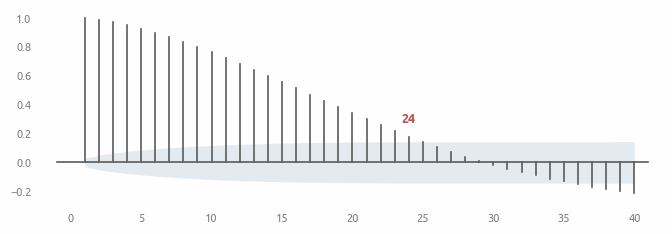

In [38]:
fig = plt.figure()
plot_acf(data=y, lags=40)

In [39]:
ts_acf_last_significant_index(y)

24

#### ACF - 300 period

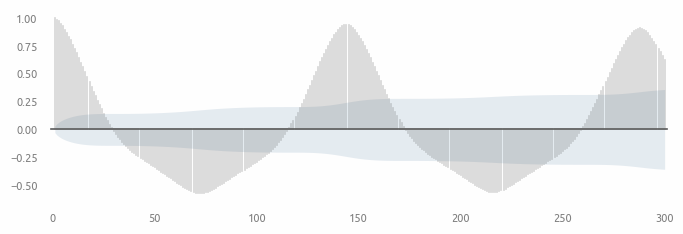

Images 'ACF_300.png' and 'ACF_300.svg' successfully saved into 'docs/img/' directory


In [40]:
fig = plt.figure()
plot_acf(data=y, lags=300, transparency_lines=0.25, show_last_significant=False)
plt.show()
savefig('ACF_300', dir_save_img)

#### PACF - 36 period

In [41]:
pacf = ts_acf_calculate(y, lags=36, partial=True)

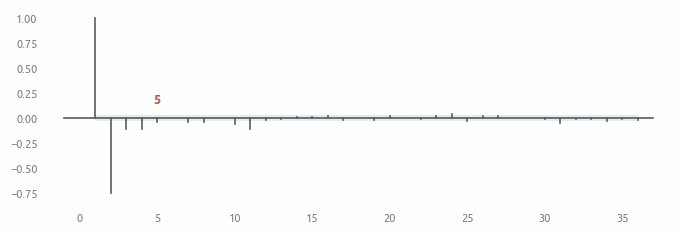

Images 'PACF.png' and 'PACF.svg' successfully saved into 'docs/img/' directory


In [42]:
fig = plt.figure()
plot_acf(data=y, lags=36, last_significant_delta=0.175, partial=True)
plt.show()
savefig('PACF', dir_save_img)

## Cross-validation Schema

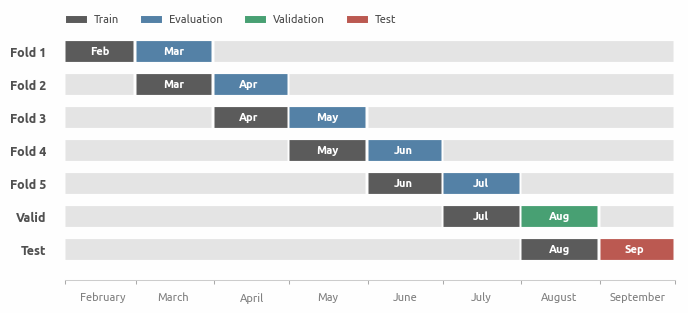

Images 'cv_schema.png' and 'cv_schema.svg' successfully saved into 'docs/img/' directory


In [43]:
train_start = dt.datetime(2017,2,1)
back_start = dt.datetime(2017,2,1)
forward_finish = dt.datetime(2017,9,30)
lw=15
k_ = 0

fig = plt.figure(figsize=(8, 3))
ax=ax_current()

for i in arange(7):
    back_finish = train_start - dt.timedelta(days=1)
    ev_start = dt.datetime(2017, train_start.month+1, 1)
    forward_start = dt.datetime(2017, train_start.month+2, 1)
    train_finish = \
        dt.datetime(2017, train_start.month+1, 1) - dt.timedelta(days=1)
    ev_finish = \
        dt.datetime(2017, train_start.month+2, 1) - dt.timedelta(days=1)
    
    range_back = pd.date_range(back_start, back_finish, freq='d')
    range_train = pd.date_range(train_start, train_finish, freq='d')
    range_ev = pd.date_range(ev_start, ev_finish, freq='d')
    range_forward = pd.date_range(forward_start, forward_finish, freq='d')

    len_train = (train_finish - train_start).days
    len_ev = (ev_finish - ev_start).days

    color_back = color_forward = alpha_color(palette[-1], 0.4)
    color_ev = alpha_color(palette[2], 1)
    
    if i == 5:
        color_ev = palette[3]
    if i == 6:
        color_ev = palette[1]

    ax.plot(
        range_back,
        [7-i]*len(range_back),
        lw=lw,
        solid_capstyle='butt',
        color=color_back)

    ax.plot(
        range_train,
        [7-i]*len(range_train),
        lw=lw,
        solid_capstyle='butt',
        color=palette[0])

    ax.plot(
        range_ev,
        [7-i]*len(range_ev),
        lw=lw,
        solid_capstyle='butt',
        color=color_ev)

    ax.plot(
        range_forward,
        [7-i]*len(range_forward),
        lw=lw,
        solid_capstyle='butt',
        color=color_forward)
    
    ax.annotate(
        train_start.strftime("%B")[:3],
        xy=(dt.datetime(2017, train_start.month,
                        int(round(len_train/2))+1), 7-i-0.1),
        ha='center',
        color='white',
        weight='bold',
        size=8)

    ax.annotate(
        ev_start.strftime("%B")[:3],
        xy=(dt.datetime(2017, ev_start.month,
                        int(round(len_ev/2))+1), 7-i-0.1),
        ha='center',
        color='white',
        weight='bold',
        size=8)
    
    train_start = dt.datetime(2017, train_start.month+1, 1)

ax.legend(
    **legend_create_handles(
        n=4, kind='r',
        labels=['Train', 'Evaluation', 'Validation', 'Test'],
        colors=[palette[0], alpha_color(palette[2], 1),
                palette[3], palette[1]],
        alphas=1),
    **legend_inline())

axis_rstyle(
    y_axis_hide=True, x_ticks_hide=True, offset_left=0, offset_bottom=10)

ax_sec = ax.secondary_xaxis('bottom')
ax_sec.set_xticks(ax.get_xticks())
ax_sec.spines['bottom'].set_visible(False)
ax_sec.spines['bottom'].set_position(('outward', 13))
ax_sec.tick_params(axis='x', labelbottom=False, size=3)

ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%B'))
ax.xaxis.set_major_locator(mpl.dates.DayLocator(bymonthday=16))

ax.set_yticks(
    ticks=arange(1, 8),
    labels=[
        'Test', 'Valid', 'Fold 5', 'Fold 4',
        'Fold 3', 'Fold 2', 'Fold 1'],
    fontsize=9,
    weight='bold',
    color=palette[0]
)
ax.tick_params(axis='y', colors='#505050')

ax.set_ylim(0.5, 7.5)

plt.show()
savefig('cv_schema', dir_save_img)

In [44]:
len(train.loc['2017-03-01':]['month'].unique())

5

In [45]:
cv_indexes_train, cv_indexes_eval = cv_split_indexes(
    data=train['target'], start='2017-03-01', train_size=1,
    test_size=1, size_unit='months', n_splits=5, freq='10min')

In [46]:
cv_indexes_train[0]

DatetimeIndex(['2017-02-01 00:00:00', '2017-02-01 00:10:00',
               '2017-02-01 00:20:00', '2017-02-01 00:30:00',
               '2017-02-01 00:40:00', '2017-02-01 00:50:00',
               '2017-02-01 01:00:00', '2017-02-01 01:10:00',
               '2017-02-01 01:20:00', '2017-02-01 01:30:00',
               ...
               '2017-02-28 22:20:00', '2017-02-28 22:30:00',
               '2017-02-28 22:40:00', '2017-02-28 22:50:00',
               '2017-02-28 23:00:00', '2017-02-28 23:10:00',
               '2017-02-28 23:20:00', '2017-02-28 23:30:00',
               '2017-02-28 23:40:00', '2017-02-28 23:50:00'],
              dtype='datetime64[ns]', length=4032, freq='10min')

In [47]:
cv_indexes_eval[0]

DatetimeIndex(['2017-03-01 00:00:00', '2017-03-01 00:10:00',
               '2017-03-01 00:20:00', '2017-03-01 00:30:00',
               '2017-03-01 00:40:00', '2017-03-01 00:50:00',
               '2017-03-01 01:00:00', '2017-03-01 01:10:00',
               '2017-03-01 01:20:00', '2017-03-01 01:30:00',
               ...
               '2017-03-31 22:20:00', '2017-03-31 22:30:00',
               '2017-03-31 22:40:00', '2017-03-31 22:50:00',
               '2017-03-31 23:00:00', '2017-03-31 23:10:00',
               '2017-03-31 23:20:00', '2017-03-31 23:30:00',
               '2017-03-31 23:40:00', '2017-03-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

In [48]:
cv_indexes_train[-1]

DatetimeIndex(['2017-06-01 00:00:00', '2017-06-01 00:10:00',
               '2017-06-01 00:20:00', '2017-06-01 00:30:00',
               '2017-06-01 00:40:00', '2017-06-01 00:50:00',
               '2017-06-01 01:00:00', '2017-06-01 01:10:00',
               '2017-06-01 01:20:00', '2017-06-01 01:30:00',
               ...
               '2017-06-30 22:20:00', '2017-06-30 22:30:00',
               '2017-06-30 22:40:00', '2017-06-30 22:50:00',
               '2017-06-30 23:00:00', '2017-06-30 23:10:00',
               '2017-06-30 23:20:00', '2017-06-30 23:30:00',
               '2017-06-30 23:40:00', '2017-06-30 23:50:00'],
              dtype='datetime64[ns]', length=4320, freq='10min')

In [49]:
cv_indexes_eval[-1]

DatetimeIndex(['2017-07-01 00:00:00', '2017-07-01 00:10:00',
               '2017-07-01 00:20:00', '2017-07-01 00:30:00',
               '2017-07-01 00:40:00', '2017-07-01 00:50:00',
               '2017-07-01 01:00:00', '2017-07-01 01:10:00',
               '2017-07-01 01:20:00', '2017-07-01 01:30:00',
               ...
               '2017-07-31 22:20:00', '2017-07-31 22:30:00',
               '2017-07-31 22:40:00', '2017-07-31 22:50:00',
               '2017-07-31 23:00:00', '2017-07-31 23:10:00',
               '2017-07-31 23:20:00', '2017-07-31 23:30:00',
               '2017-07-31 23:40:00', '2017-07-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

## Choose AR, I, MA parameters

### Cross-validation 0: AR, I, MA parameters

5-Fold CV:

- All combinations from 1 to 6 for AR and MA parameters  
- 0 and 1 for I parameter

In [50]:
%%time
if cv0:
    cv0_results_dict=cv0.copy()  
else:
    cv0_results_dict = {}
    # for all combinations of (1,1), (1,2), (1,3) ... (6,6)
    for i in [0, 1]:
        for arma in itertools.product(arange(1,6,True), repeat=2):
            
            order = (arma[0], i, arma[1])
            model_name = f'ARIMA {order}'
            rmse0_list = []
            
            for idx_train, idx_eval in zip(cv_indexes_train, cv_indexes_eval):
                
                rmse0_local = cv_arima_evaluation_error(
                    data_train=train.loc[idx_train, target],
                    data_eval=train.loc[idx_eval, target],
                    order=order,
                    metric=root_mean_squared_error,
                    exec_time=False,
                    clear_output_include=False)
                
                rmse0_list.append(rmse0_local)
                
            cv0_results_dict[model_name] = rmse0_list
            print(f'Evaluation of model ARIMA ({order}) is finished')
        
    clear_output()

CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 28.8 µs


In [51]:
cv0_results_df = pd.DataFrame(cv0_results_dict)

In [52]:
pd.DataFrame(cv0_results_df.mean().sort_values(), columns=['RMSE Mean']).head(40)

,RMSE Mean
"ARIMA (4, 1, 5)",7303.664716
"ARIMA (2, 1, 1)",7519.199170
"ARIMA (4, 1, 6)",7570.347830
"ARIMA (5, 1, 6)",7707.666256
"ARIMA (5, 1, 5)",7751.246581
"ARIMA (6, 1, 5)",7798.087172
"ARIMA (1, 1, 1)",7843.911236
"ARIMA (6, 1, 6)",8024.138951
"ARIMA (4, 1, 2)",8102.384545
"ARIMA (3, 1, 3)",8118.864223


In [53]:
arima415 = SARIMAX(
    endog=y, exog=None,
    order=(4,1,5),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [54]:
print(arima415.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                 4464
Model:               SARIMAX(4, 1, 5)   Log Likelihood              -33588.460
Date:                Fri, 17 May 2024   AIC                          67196.919
Time:                        11:00:35   BIC                          67260.955
Sample:                    03-01-2017   HQIC                         67219.492
                         - 03-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2747      1.681      0.758      0.448      -2.021       4.570
ar.L2         -1.0380      0.850     -1.221      0.222      -2.704       0.628
ar.L3          1.2676      1.114      1.138      0.2

In [55]:
arima211 = SARIMAX(
    endog=y, exog=None,
    order=(2,1,1),
    seasonal_order=(0, 0, 0, 0)
).fit(maxiter=1000, disp=False)

In [56]:
print(arima211.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                 4464
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -33599.766
Date:                Fri, 17 May 2024   AIC                          67207.533
Time:                        11:00:36   BIC                          67233.147
Sample:                    03-01-2017   HQIC                         67216.562
                         - 03-31-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0840      0.062     17.546      0.000       0.963       1.205
ar.L2         -0.2069      0.044     -4.701      0.000      -0.293      -0.121
ma.L1         -0.4988      0.061     -8.200      0.0

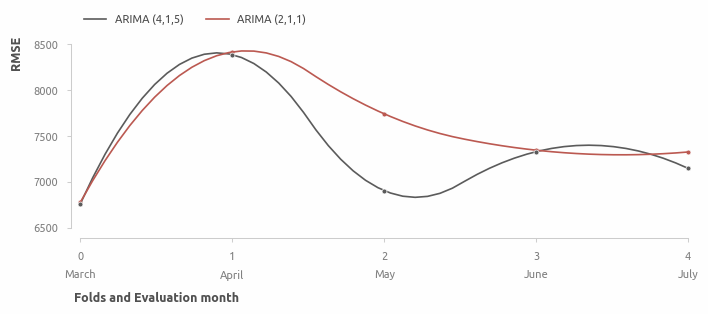

Images 'cv0_best_plot.png' and 'cv0_best_plot.svg' successfully saved into 'docs/img/' directory


In [57]:
fig = plt.figure()

plt.scatter(
    x=cv0_results_df['ARIMA (4, 1, 5)'].index,
    y=cv0_results_df['ARIMA (4, 1, 5)'],
    s=50,
    zorder=10,
    lw=0.5)
plt.plot(
    smoothed(cv0_results_df['ARIMA (4, 1, 5)'], n=50, k=2), label='ARIMA (4,1,5)')
plt.scatter(
    x=cv0_results_df['ARIMA (2, 1, 1)'].index,
    y=cv0_results_df['ARIMA (2, 1, 1)'],
    s=50,
    lw=0.5)
plt.plot(
    smoothed(cv0_results_df['ARIMA (2, 1, 1)'], n=50, k=2), label='ARIMA (2,1,1)')

axis_rstyle(
    offset_bottom=7.5, offset_left=2.5,
    xticks=[0,4,1], yticks=[6500, 8500, 500], ylim=[6500, 8600])
plt.legend(**legend_inline())
plt.xlabel('Folds and Evaluation month', labelpad=22)
plt.ylabel('RMSE')

ax_sec = axis_secondary(pad=30, xticks=arange(5), xlabels=months_list[2:7])

plt.show()

savefig('cv0_best_plot', dir_save_img)

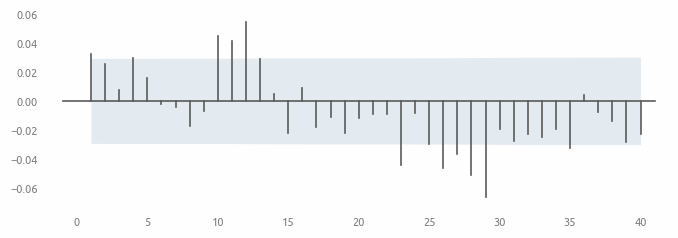

In [58]:
# should plot resid[d:], where d is d-order of ARIMA model
plot_acf(data=arima415.resid[1:])

## Managing seasonality and adding features

### Stationarity of covariates

In [59]:
# NULL: non-stationarity
sm.tsa.stattools.adfuller(train.loc['2017-07-01':, 'target_previous_month'])

(-10.780262352765597,
 2.264652307844371e-19,
 25,
 4438,
 {'1%': -3.4318243322143682,
  '5%': -2.8621914772569323,
  '10%': -2.567116785250736},
 67265.01178270859)

### Fourier transform for seasonal patterns

In [60]:
y_values = train.loc['2017-05', target].values

In [61]:
y_values_trend = scipy.signal.savgol_filter(y_values, 25, 1)

In [62]:
y_values_detrended = y_values - y_values_trend

In [63]:
fft_x = np.fft.fftfreq(len(y_values_detrended))
fft_x = fft_x[:len(fft_x)//2]

In [64]:
fft_y = np.fft.fft(y_values_detrended)
fft_y = np.abs(fft_y[:len(fft_y)//2])

In [65]:
fft_y_peaks_indices = get_peaks_indicies(fft_y, boundary=500000)

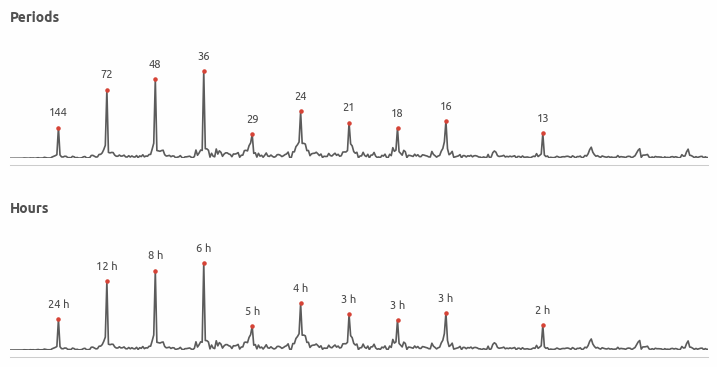

Images 'fourier_transform.png' and 'fourier_transform.svg' successfully saved into 'docs/img/' directory


In [66]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4))

plt.subplot(2, 1, 1)
plt.plot(fft_x, fft_y)
for idx in fft_y_peaks_indices:
    x_, y_ = fft_x[idx], fft_y[idx]
    text = f'{round(1/x_)}'
    plt.annotate(text, (x_, y_+300000), ha='center', size=8)
    plt.scatter(
        fft_x[idx], fft_y[idx],
        color=saturate_color(palette[1], 1.5), marker='.', s=20, zorder=10)

plt.title('Periods')
plt.xlim(0, 0.1)
plt.ylim(0, 3000000)
axis_rstyle(y_axis_hide=True, y_ticklabels_hide=True, x_ticklabels_hide=True, x_ticks_hide=True)

plt.subplot(2, 1, 2)
plt.plot(fft_x, fft_y)
for idx in fft_y_peaks_indices:
    x_, y_ = fft_x[idx], fft_y[idx]
    text = f'{round(1/x_/6)} h'
    plt.annotate(text, (x_, y_+300000), ha='center', size=8)
    plt.scatter(
        fft_x[idx], fft_y[idx],
        color=saturate_color(palette[1], 1.5), marker='.', s=20, zorder=10)

plt.title('Hours')
plt.xlim(0, 0.1)
plt.ylim(0, 3000000)
axis_rstyle(y_axis_hide=True, y_ticklabels_hide=True, x_ticklabels_hide=True, x_ticks_hide=True)

plt.subplots_adjust(hspace=0.65)
plt.show()

savefig('fourier_transform', dir_save_img)

### Cross-validation 1: Fourier period and order

5-Fold CV:

- Models: ARIMA (4,1,5), ARIMA (2,1,1)
- Periods: all combinations from 144 to (144, 72, 48, 36)
- Orders: 2 to 4 (equal orders, without conbinations)

Explore optimal Fourier period and order

In [67]:
cv_indexes_train[0]

DatetimeIndex(['2017-02-01 00:00:00', '2017-02-01 00:10:00',
               '2017-02-01 00:20:00', '2017-02-01 00:30:00',
               '2017-02-01 00:40:00', '2017-02-01 00:50:00',
               '2017-02-01 01:00:00', '2017-02-01 01:10:00',
               '2017-02-01 01:20:00', '2017-02-01 01:30:00',
               ...
               '2017-02-28 22:20:00', '2017-02-28 22:30:00',
               '2017-02-28 22:40:00', '2017-02-28 22:50:00',
               '2017-02-28 23:00:00', '2017-02-28 23:10:00',
               '2017-02-28 23:20:00', '2017-02-28 23:30:00',
               '2017-02-28 23:40:00', '2017-02-28 23:50:00'],
              dtype='datetime64[ns]', length=4032, freq='10min')

In [68]:
cv_indexes_eval[0]

DatetimeIndex(['2017-03-01 00:00:00', '2017-03-01 00:10:00',
               '2017-03-01 00:20:00', '2017-03-01 00:30:00',
               '2017-03-01 00:40:00', '2017-03-01 00:50:00',
               '2017-03-01 01:00:00', '2017-03-01 01:10:00',
               '2017-03-01 01:20:00', '2017-03-01 01:30:00',
               ...
               '2017-03-31 22:20:00', '2017-03-31 22:30:00',
               '2017-03-31 22:40:00', '2017-03-31 22:50:00',
               '2017-03-31 23:00:00', '2017-03-31 23:10:00',
               '2017-03-31 23:20:00', '2017-03-31 23:30:00',
               '2017-03-31 23:40:00', '2017-03-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

In [69]:
cv_indexes_train[-1]

DatetimeIndex(['2017-06-01 00:00:00', '2017-06-01 00:10:00',
               '2017-06-01 00:20:00', '2017-06-01 00:30:00',
               '2017-06-01 00:40:00', '2017-06-01 00:50:00',
               '2017-06-01 01:00:00', '2017-06-01 01:10:00',
               '2017-06-01 01:20:00', '2017-06-01 01:30:00',
               ...
               '2017-06-30 22:20:00', '2017-06-30 22:30:00',
               '2017-06-30 22:40:00', '2017-06-30 22:50:00',
               '2017-06-30 23:00:00', '2017-06-30 23:10:00',
               '2017-06-30 23:20:00', '2017-06-30 23:30:00',
               '2017-06-30 23:40:00', '2017-06-30 23:50:00'],
              dtype='datetime64[ns]', length=4320, freq='10min')

In [70]:
cv_indexes_eval[-1]

DatetimeIndex(['2017-07-01 00:00:00', '2017-07-01 00:10:00',
               '2017-07-01 00:20:00', '2017-07-01 00:30:00',
               '2017-07-01 00:40:00', '2017-07-01 00:50:00',
               '2017-07-01 01:00:00', '2017-07-01 01:10:00',
               '2017-07-01 01:20:00', '2017-07-01 01:30:00',
               ...
               '2017-07-31 22:20:00', '2017-07-31 22:30:00',
               '2017-07-31 22:40:00', '2017-07-31 22:50:00',
               '2017-07-31 23:00:00', '2017-07-31 23:10:00',
               '2017-07-31 23:20:00', '2017-07-31 23:30:00',
               '2017-07-31 23:40:00', '2017-07-31 23:50:00'],
              dtype='datetime64[ns]', length=4464, freq='10min')

In [71]:
fourier_periods = [
    [144],
    [144, 72],
    [144, 72, 48],
    [144, 72, 48, 36]
]

In [72]:
fourier_orders = [2, 3, 4]

In [73]:
model_orders = [
    (2, 1, 1),
    (4, 1, 5)
]

In [74]:
%%time

if cv1:
    cv1_results_dict=cv1.copy()
else:
    cv1_results_dict = {}
    for order in model_orders:
        for f_period in fourier_periods:
            for fourier_order in fourier_orders:
                f_order = [fourier_order] * len(f_period)
                model_name = f'ARIMA {order} {tuple(f_period)} {tuple(f_order)}'
                rmse1_list = []
                
                for idx_train, idx_eval in zip(cv_indexes_train, cv_indexes_eval):
    
                    train_data = train.loc[idx_train, target]
                    eval_data = train.loc[idx_eval, target]
    
                    train_w_exogs, eval_w_exogs = \
                        datasets_w_fourier(
                            fourier_period=f_period,
                            fourier_order=f_order,
                            train_data=train_data,
                            eval_data=eval_data,
                            train_exog=train.loc[idx_train, features],
                            eval_exog=train.loc[idx_eval, features])      
    
                    rmse1_local = cv_arima_evaluation_error(
                        data_train=train_data,
                        data_eval=eval_data,
                        order=order,
                        exog_train=train_w_exogs,
                        exog_eval=eval_w_exogs,
                        metric=root_mean_squared_error,
                        exec_time=False,
                        clear_output_include=False)
    
                    rmse1_list.append(rmse1_local)
    
                cv1_results_dict[model_name] = rmse1_list
                print(f'Evaluation of model {model_name} is finished')
                
    clear_output()

CPU times: user 14 µs, sys: 4 µs, total: 18 µs
Wall time: 26 µs


In [75]:
cv1_results_df = pd.DataFrame(cv1_results_dict)

In [76]:
cv1_results_df

,"ARIMA (2, 1, 1) (144,) (2,)","ARIMA (2, 1, 1) (144,) (3,)","ARIMA (2, 1, 1) (144,) (4,)","ARIMA (2, 1, 1) (144, 72) (2, 2)","ARIMA (2, 1, 1) (144, 72) (3, 3)","ARIMA (2, 1, 1) (144, 72) (4, 4)","ARIMA (2, 1, 1) (144, 72, 48) (2, 2, 2)","ARIMA (2, 1, 1) (144, 72, 48) (3, 3, 3)","ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 4)","ARIMA (2, 1, 1) (144, 72, 48, 36) (2, 2, 2, 2)",...,"ARIMA (4, 1, 5) (144,) (4,)","ARIMA (4, 1, 5) (144, 72) (2, 2)","ARIMA (4, 1, 5) (144, 72) (3, 3)","ARIMA (4, 1, 5) (144, 72) (4, 4)","ARIMA (4, 1, 5) (144, 72, 48) (2, 2, 2)","ARIMA (4, 1, 5) (144, 72, 48) (3, 3, 3)","ARIMA (4, 1, 5) (144, 72, 48) (4, 4, 4)","ARIMA (4, 1, 5) (144, 72, 48, 36) (2, 2, 2, 2)","ARIMA (4, 1, 5) (144, 72, 48, 36) (3, 3, 3, 3)","ARIMA (4, 1, 5) (144, 72, 48, 36) (4, 4, 4, 4)"
0,4176.918575,1817.035010,1826.037357,4162.986029,1876.286358,1924.621139,1876.284607,1855.921664,1931.100256,1924.602562,...,1870.328233,4213.261630,1896.888398,1957.870881,1903.135835,1913.802095,1926.762063,1957.885326,1929.778687,1935.495340
1,4254.743914,2545.759263,1992.133181,3771.786591,2025.458528,1988.731085,2025.459911,2018.516579,1981.578932,1988.728625,...,2128.610178,2660.552437,2139.368140,2095.024460,2139.380041,2141.638688,1989.425842,2094.979521,1989.425405,2003.245692
2,4776.777352,3409.871276,2742.756733,3939.394613,2884.106786,2726.233169,2884.106786,2794.979486,2676.781127,2726.233170,...,2684.060932,4073.094246,2944.388971,2953.631391,2944.389215,2688.719061,2919.061875,2953.631067,2919.060702,2956.736273
3,4616.359183,4642.470249,4658.809261,4930.712563,4698.025080,4734.542189,4698.084804,4722.398160,4759.396635,4734.543977,...,4660.732979,4535.828748,4698.621966,4735.712295,4699.228311,4724.682890,4760.651859,4735.548684,4762.431028,4763.528557
4,9273.729030,8427.225561,6019.664304,6261.578982,6063.449183,6052.972046,6063.449235,6056.539454,6038.589031,6052.977901,...,6001.224409,6251.847948,6025.424724,6028.473222,6022.760043,6029.169054,6012.129428,6023.234976,6024.416903,6006.542797


In [77]:
cv1_results_mean = cv1_results_df.mean(axis=0)

In [78]:
cv1_results_mean_std = cv1_results_df.std()

In [79]:
cv1_results_mean.sort_values()

ARIMA (2, 1, 1) (144,) (4,)                       3447.880167
ARIMA (4, 1, 5) (144,) (4,)                       3468.991346
ARIMA (2, 1, 1) (144, 72, 48, 36) (3, 3, 3, 3)    3477.486594
ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 4)           3477.489196
ARIMA (2, 1, 1) (144, 72, 48, 36) (4, 4, 4, 4)    3481.697761
ARIMA (2, 1, 1) (144, 72, 48, 36) (2, 2, 2, 2)    3485.417247
ARIMA (2, 1, 1) (144, 72) (4, 4)                  3485.419926
ARIMA (2, 1, 1) (144, 72, 48) (3, 3, 3)           3489.671068
ARIMA (4, 1, 5) (144, 72, 48) (3, 3, 3)           3499.602358
ARIMA (2, 1, 1) (144, 72) (3, 3)                  3509.465187
ARIMA (2, 1, 1) (144, 72, 48) (2, 2, 2)           3509.477069
ARIMA (4, 1, 5) (144, 72, 48) (4, 4, 4)           3521.606213
ARIMA (4, 1, 5) (144, 72, 48, 36) (3, 3, 3, 3)    3525.022545
ARIMA (4, 1, 5) (144, 72, 48, 36) (4, 4, 4, 4)    3533.109732
ARIMA (4, 1, 5) (144, 72) (3, 3)                  3540.938440
ARIMA (4, 1, 5) (144, 72, 48) (2, 2, 2)           3541.778689
ARIMA (4

In [80]:
cv1_results_plot_labels = [i[16:] for i in cv1_results_mean.index]

In [81]:
cv1_results_best_model = cv1_results_mean.sort_values().index[0]
cv1_results_best_model_index = \
    list(cv1_results_mean.index).index(cv1_results_best_model)

In [82]:
cv1_results_second_best_model = cv1_results_mean.sort_values().index[1]
cv1_results_second_best_model_index = \
    list(cv1_results_mean.index).index(cv1_results_second_best_model)

In [83]:
cv1_results_stable_model = cv1_results_mean_std.sort_values().index[0]
cv1_results_stable_model_index = \
    list(cv1_results_mean.index).index(cv1_results_stable_model)

In [84]:
cv1_results_complicated_model = cv1_results_mean.sort_values().index[2]
cv1_results_complicated_model_index = \
    list(cv1_results_mean.index).index(cv1_results_complicated_model)

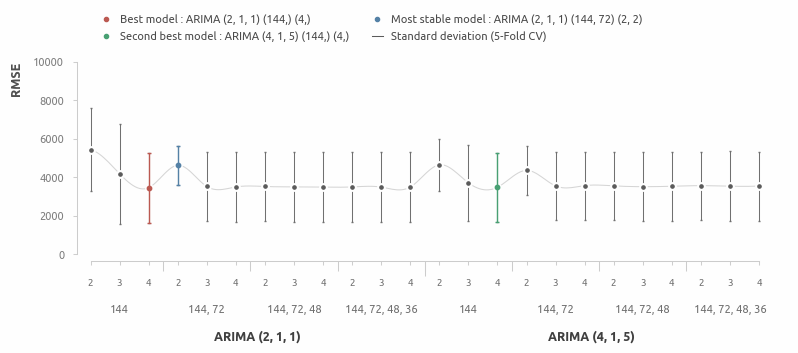

Images 'cv1_results_plot.png' and 'cv1_results_plot.svg' successfully saved into 'docs/img/' directory


In [85]:
fig = plt.figure(figsize=(9, 2.5))
ax = ax_current()

plt.plot(smoothed(cv1_results_mean.values), lw=0.75, alpha=0.25)
plt.scatter(
    x=arange(len(cv1_results_mean)),
    y=cv1_results_mean, s=95, lw=1.5, clip_on=False, zorder=10)

plt.scatter(
    cv1_results_best_model_index,
    cv1_results_mean[cv1_results_best_model],
    s=40, color=palette[1],
    label=f'Best model : {cv1_results_best_model}',
    clip_on=False, zorder=100)

plt.scatter(
    cv1_results_second_best_model_index,
    cv1_results_mean[cv1_results_second_best_model],
    s=40, color=palette[3],
    label=f'Second best model : {cv1_results_second_best_model}',
    clip_on=False, zorder=100)

plt.scatter(
    cv1_results_stable_model_index,
    cv1_results_mean[cv1_results_stable_model],
    s=40, color=palette[2],
    label=f'Most stable model : {cv1_results_stable_model}',
    clip_on=False, zorder=100)

plt.errorbar(
    x=arange(len(cv1_results_mean)),
    y=cv1_results_mean,
    yerr=cv1_results_mean_std,
    c=palette[-1],
    linestyle='none',
    elinewidth=0.75,
    capsize=1,
    ecolor=palette[-3],
    # alpha=0.75,
    clip_on=False,
    zorder=1,
    label='Standard deviation (5-Fold CV)')

plt.errorbar(
    x=cv1_results_best_model_index,
    y=cv1_results_mean.loc[cv1_results_best_model],
    yerr=cv1_results_mean_std.loc[cv1_results_best_model],
    c=palette[1],
    linestyle='none',
    elinewidth=1,
    capsize=1.2,
    ecolor=palette[1],
    clip_on=False,
    # alpha=0.75,
    zorder=12)

plt.errorbar(
    x=cv1_results_second_best_model_index,
    y=cv1_results_mean.loc[cv1_results_second_best_model],
    yerr=cv1_results_mean_std.loc[cv1_results_second_best_model],
    c=palette[1],
    linestyle='none',
    elinewidth=1,
    capsize=1.2,
    ecolor=palette[3],
    clip_on=False,
    # alpha=0.75,
    zorder=12)

plt.errorbar(
    x=cv1_results_stable_model_index,
    y=cv1_results_mean.loc[cv1_results_stable_model],
    yerr=cv1_results_mean_std.loc[cv1_results_stable_model],
    c=palette[1],
    linestyle='none',
    elinewidth=1,
    capsize=1.2,
    ecolor=palette[2],
    clip_on=False,
    # alpha=0.75,
    zorder=12)

axis_rstyle(
    offset_left=10, offset_bottom=5,
    ylim=[0, 10000], yticks=[0, 10000, 2000],
    xlim=[0, len(cv1_results_mean)],
    x_spine_lim=[0, len(cv1_results_mean)-1])

plt.xticks(
    ticks=arange(len(cv1_results_mean)),
    labels=cv1_results_plot_labels, rotation=30, ha='center')

ax.tick_params(axis='x', labelbottom=False)

ax0 = axis_secondary(pad=18)
ax0_xticklabels = ['2', '3', '4']
# for i in arange(1, 4):
    # ax0_xticklabels.extend([j+f', {j[-1]}' for j in ax0_xticklabels[-3:]])
    # ax0_xticklabels.extend([j+f',{j[-1]}' for j in ax0_xticklabels[-3:]])
# ax0_xticklabels = ax0_xticklabels*2
ax0_xticklabels = ax0_xticklabels*8
# ax0.set_xticks(ax.get_xticks()[::2], ax0_xticklabels[::2])
ax0.set_xticks(ax.get_xticks(), ax0_xticklabels)
ax0.tick_params(labelsize=7, labelcolor='#707070')

# ax1 = axis_secondary(pad=25)
# ax1.set_xticks(ax.get_xticks()[1::2], ax0_xticklabels[1::2])
# ax1.tick_params(labelsize=7, labelcolor='#707070')

ax2 = axis_secondary(pad=36)
ax2.set_xticks(ax.get_xticks()[1::3])
ax2_xticklabels = ['144', '144, 72', '144, 72, 48', '144, 72, 48, 36']*2
ax2.set_xticklabels(labels=ax2_xticklabels, size=8, color='#707070')

ax22 = axis_secondary()
ax22.spines['bottom'].set_position(('outward', 12))
ax22.tick_params(bottom=True, labelbottom=False, size=7, pad=0, color='#CCCCCC')
ax22.set_xticks(np.linspace(ax.get_xticks()[0], ax.get_xticks()[-1], 2*len(ax.get_xticks())-1)[5::6])

ax3 = axis_secondary(pad=0)
ax3.spines['bottom'].set_position(('outward', 16))
ax3.tick_params(bottom=True, labelbottom=False, size=11, pad=0, color='#CCCCCC')
ax3.set_xticks(np.linspace(ax.get_xticks()[0], ax.get_xticks()[-1], 5))
for i in ax3.xaxis.get_major_ticks()[1:-1][::2]:
    i.set_visible(False)
ax3.xaxis.get_major_ticks()[0].set_visible(False)
ax3.xaxis.get_major_ticks()[-1].set_visible(False)

ax4 = axis_secondary(pad=0)
ax4.spines['bottom'].set_position(('outward', 55))
ax4.set_xticks(np.linspace(ax.get_xticks()[0], ax.get_xticks()[-1], 5))
ax4.set_xticklabels(
    labels=['', 'ARIMA (2, 1, 1)', '' , 'ARIMA (4, 1, 5)', ''],
    weight='bold', color='#404040', size=9)

plt.legend(
    **legend_inline(2, bbox_to_anchor=(0, 1.05)),
    **legend_create_handles(
        4, kind=['p', 'p', 'p', 'l'],
        colors=[palette[1], palette[3], palette[2], palette[0]],
        linewidth=0.75, linelength=1))

plt.ylabel('RMSE')
plt.show()

savefig('cv1_results_plot', dir_save_img)

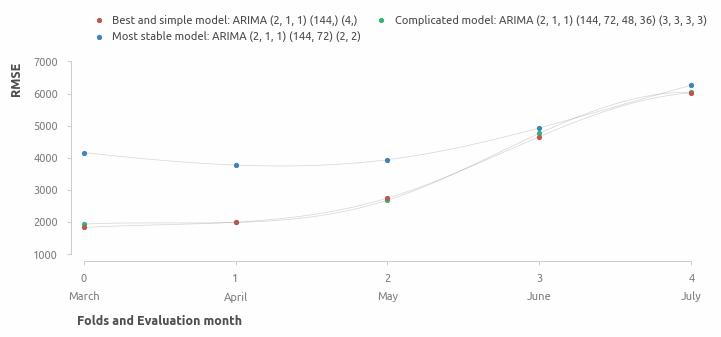

Images 'cv1_results_plot1.png' and 'cv1_results_plot1.svg' successfully saved into 'docs/img/' directory


In [86]:
fig = plt.figure()

plt.plot(
    smoothed(cv1_results_df[cv1_results_best_model]),
    lw=0.5, color=palette[0], alpha=0.25)
plt.scatter(
    x=cv1_results_df.index,
    y=cv1_results_df[cv1_results_best_model],
    s=30, color=palette[1], zorder=10,
    label=f'Best and simple model: {cv1_results_best_model}',)

plt.plot(
    smoothed(cv1_results_df[cv1_results_stable_model]),
    lw=0.5, color=palette[0], alpha=0.25)
plt.scatter(
    x=cv1_results_df.index,
    y=cv1_results_df[cv1_results_stable_model],
    s=30, color=saturate_color(palette[2], 1.5), zorder=11,
    label=f'Most stable model: {cv1_results_stable_model}')

plt.plot(
    smoothed(cv1_results_df[cv1_results_complicated_model]),
    lw=0.5, color=palette[0], alpha=0.25)
plt.scatter(
    x=cv1_results_df.index,
    y=cv1_results_df[cv1_results_complicated_model],
    s=30, color=saturate_color(palette[3], 1.5), zorder=9,
    label=f'Complicated model: {cv1_results_complicated_model}')

axis_rstyle(offset_left=5, offset_bottom=5, xticks=[0,4,1])

plt.legend(
    **legend_inline(2, bbox_to_anchor=(0, 1.05)),
    handletextpad=0.25, columnspacing=0.75)
plt.xlabel('Folds and Evaluation month', labelpad=22)
plt.ylabel('RMSE')

ax_sec = axis_secondary(pad=27, xticks=arange(5), xlabels=months_list[2:7])

plt.show()

savefig('cv1_results_plot1', dir_save_img)

### Cross-validation 2: Fourier orders for best model

5-Fold CV:

- Model: ARIMA (2,1,1)(144)
- Orders: 4 to 8 (equal orders, without comvinations)

Explore the effect of larger Fourier order on best model

In [87]:
cv1_results_best_model

'ARIMA (2, 1, 1) (144,) (4,)'

In [88]:
cv1_results_best_model_order_str = \
    cv1_results_best_model[
        index_for_occurrence(cv1_results_best_model, '(', 1): \
        index_for_occurrence(cv1_results_best_model, ')', 1)+1
    ]

In [89]:
cv1_results_best_model_order = (
    int(cv1_results_best_model_order_str[1]), 
    int(cv1_results_best_model_order_str[4]), 
    int(cv1_results_best_model_order_str[7])
)

In [90]:
cv1_results_best_model_f_period_str = \
    cv1_results_best_model[
        index_for_occurrence(cv1_results_best_model, '(', 2)+1: \
        index_for_occurrence(cv1_results_best_model, ')', 2)
    ]

In [91]:
if cv1_results_best_model_f_period_str[-1] == ',':
    cv1_results_best_model_f_period = [int(cv1_results_best_model_f_period_str[:-1])]
else:
    cv1_results_best_model_f_period = \
        [int(i) for i in cv1_results_best_model_f_period_str.split(',')]

In [92]:
cv1_results_best_model_f_order_str = \
    cv1_results_best_model[
        index_for_occurrence(cv1_results_best_model, '(', 3)+1: \
        index_for_occurrence(cv1_results_best_model, ')', 3)
    ]

In [93]:
if cv1_results_best_model_f_order_str[-1] == ',':
    cv1_results_best_model_f_order = [int(cv1_results_best_model_f_order_str[:-1])]
else:
    cv1_results_best_model_f_order = \
        [int(i) for i in cv1_results_best_model_f_order_str.split(',')]

In [94]:
%%time
if cv2:
    cv2_results_dict = cv2.copy()
else:
    if len(cv1_results_best_model_f_order) == 1:
        
        cv1_results_best_model_f_order_fin = cv1_results_best_model_f_order[0] + 5
        cv2_fourier_orders = \
            arange(cv1_results_best_model_f_order[0], cv1_results_best_model_f_order_fin)
    
        cv2_results_dict = {}
        for fourier_order in cv2_fourier_orders:
            
            f_order = [fourier_order]
            model_name_1 = cv1_results_best_model_order
            model_name_2 = tuple(cv1_results_best_model_f_period)
            model_name_3 = tuple(f_order)
            model_name = f'ARIMA {model_name_1} ({model_name_2}) {model_name_3}'
            rmse2_list = []
            
            for idx_train, idx_eval in zip(cv_indexes_train, cv_indexes_eval):
        
                train_data = train.loc[idx_train, target]
                eval_data = train.loc[idx_eval, target]
    
                train_w_exogs, eval_w_exogs = \
                    datasets_w_fourier(
                        fourier_period=cv1_results_best_model_f_period,
                        fourier_order=f_order,
                        train_data=train_data,
                        eval_data=eval_data,
                        train_exog=train.loc[idx_train, features],
                        eval_exog=train.loc[idx_eval, features])            
        
                rmse2_local = cv_arima_evaluation_error(
                    data_train=train_data,
                    data_eval=eval_data,
                    order=cv1_results_best_model_order,
                    exog_train=train_w_exogs,
                    exog_eval=eval_w_exogs,
                    metric=root_mean_squared_error,
                    exec_time=False,
                    clear_output_include=False)
                
                rmse2_list.append(rmse2_local)
        
            cv2_results_dict[model_name] = rmse2_list
            print(f'Evaluation of model {model_name} is finished')

        clear_output()

CPU times: user 7 µs, sys: 1 µs, total: 8 µs
Wall time: 11 µs


In [95]:
cv2_results_df = pd.DataFrame(cv2_results_dict)  

In [96]:
cv2_results_df

,"ARIMA (2, 1, 1) ((144,)) (4,)","ARIMA (2, 1, 1) ((144,)) (5,)","ARIMA (2, 1, 1) ((144,)) (6,)","ARIMA (2, 1, 1) ((144,)) (7,)","ARIMA (2, 1, 1) ((144,)) (8,)"
0,1826.037357,1797.371590,1876.925024,1844.795731,1900.428397
1,1992.133181,2138.149095,2163.436139,2270.809231,2207.034016
2,2742.756733,2834.565329,3023.323730,3006.584011,2825.232366
3,4658.809261,4646.086744,4685.676447,4686.697705,4723.435547
4,6019.664304,5969.214151,6026.828291,6649.764510,6703.785799


In [97]:
cv2_results_df.mean().sort_values()

ARIMA (2, 1, 1) ((144,)) (4,)    3447.880167
ARIMA (2, 1, 1) ((144,)) (5,)    3477.077382
ARIMA (2, 1, 1) ((144,)) (6,)    3555.237926
ARIMA (2, 1, 1) ((144,)) (8,)    3671.983225
ARIMA (2, 1, 1) ((144,)) (7,)    3691.730237
dtype: float64

### Cross-validation 3: Fourier period increase and orders research

5-Fold CV:

- Model: ARIMA (2,1,1)
- Fourier periods: [144], [144, 72], [144, 72, 48],
- Orders: 4 to 6 (all conbinations)

Explore the effect of combinations Fourier order on best model

In [98]:
model_orders = [(2,1,1)]

In [99]:
fourier_periods = [
    [144, 72, 48],
    [144, 72],
    [144]
]

In [100]:
fourier_orders = arange(4,6,True)

In [101]:
%%time

if cv3:
    cv3_results_dict = cv3.copy()
else:

    cv3_results_dict = {}
    for order in model_orders:
        for f_period in fourier_periods:
            for f_order in itertools.product(fourier_orders, repeat=len(f_period)):
                
                model_name = f'ARIMA {order} {tuple(f_period)} {tuple(f_order)}'
                rmse3_list = []
                
                for idx_train, idx_eval in zip(cv_indexes_train, cv_indexes_eval):
    
                    train_data = train.loc[idx_train, target]
                    eval_data = train.loc[idx_eval, target]
    
                    train_w_exogs, eval_w_exogs = \
                        datasets_w_fourier(
                            fourier_period=f_period,
                            fourier_order=f_order,
                            train_data=train_data,
                            eval_data=eval_data,
                            train_exog=train.loc[idx_train, features],
                            eval_exog=train.loc[idx_eval, features])
    
                    rmse3_local = cv_arima_evaluation_error(
                        data_train=train_data,
                        data_eval=eval_data,
                        order=order,
                        exog_train=train_w_exogs,
                        exog_eval=eval_w_exogs,
                        metric=root_mean_squared_error,
                        exec_time=False,
                        clear_output_include=False)
    
                    rmse3_list.append(rmse3_local)
    
                cv3_results_dict[model_name] = rmse3_list
                print(f'Evaluation of model {model_name} is finished')
    
    clear_output()

CPU times: user 14 µs, sys: 2 µs, total: 16 µs
Wall time: 21.9 µs


In [102]:
cv3_results_df = pd.DataFrame(cv3_results_dict)

In [103]:
cv3_results_df

,"ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 4)","ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 5)","ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 6)","ARIMA (2, 1, 1) (144, 72, 48) (4, 5, 4)","ARIMA (2, 1, 1) (144, 72, 48) (4, 5, 5)","ARIMA (2, 1, 1) (144, 72, 48) (4, 5, 6)","ARIMA (2, 1, 1) (144, 72, 48) (4, 6, 4)","ARIMA (2, 1, 1) (144, 72, 48) (4, 6, 5)","ARIMA (2, 1, 1) (144, 72, 48) (4, 6, 6)","ARIMA (2, 1, 1) (144, 72, 48) (5, 4, 4)",...,"ARIMA (2, 1, 1) (144, 72) (4, 6)","ARIMA (2, 1, 1) (144, 72) (5, 4)","ARIMA (2, 1, 1) (144, 72) (5, 5)","ARIMA (2, 1, 1) (144, 72) (5, 6)","ARIMA (2, 1, 1) (144, 72) (6, 4)","ARIMA (2, 1, 1) (144, 72) (6, 5)","ARIMA (2, 1, 1) (144, 72) (6, 6)","ARIMA (2, 1, 1) (144,) (4,)","ARIMA (2, 1, 1) (144,) (5,)","ARIMA (2, 1, 1) (144,) (6,)"
0,1931.100256,1920.975182,1921.351092,2010.710568,1998.863219,1999.982339,2010.629793,1998.889365,1999.998059,1959.540698,...,2032.107182,1935.043319,2008.158746,1976.181639,1935.048467,2008.161175,1976.177436,1826.037357,1797.371590,1876.925024
1,1981.578932,1986.194666,1982.873612,1968.813636,1971.347450,1972.332484,1968.808530,1971.342861,1972.331467,2127.918500,...,1955.376201,2118.494832,2113.795994,2117.742423,2118.499603,2113.795991,2117.745843,1992.133181,2138.149095,2163.436139
2,2676.781127,2693.720465,2682.450517,2731.797940,2751.284889,2736.018557,2731.797948,2751.284896,2736.018562,2775.469907,...,2804.446364,2837.607351,2936.359383,2950.914805,2837.607351,2936.359378,2950.914799,2742.756733,2834.565329,3023.323730
3,4759.396635,4763.453328,4776.861189,4759.833772,4764.052366,4777.951823,4759.895070,4764.053275,4777.952764,4748.442234,...,4733.691182,4722.432104,4722.527801,4721.335887,4722.435336,4722.527380,4721.336111,4658.809261,4646.086744,4685.676447
4,6038.589031,6034.315400,6001.552994,6059.156963,6055.293680,7050.104550,6059.157962,6054.801372,7050.104553,5987.984095,...,6067.841985,6007.352311,6020.962221,6013.834735,6007.354845,6020.962370,6013.834771,6019.664304,5969.214151,6026.828291


In [104]:
cv3_results_df['ARIMA (2, 1, 1) (144,) (4,)']

0    1826.037357
1    1992.133181
2    2742.756733
3    4658.809261
4    6019.664304
Name: ARIMA (2, 1, 1) (144,) (4,), dtype: float64

In [105]:
cv3_results_df.iloc[:, :50].mean().sort_values().head()

ARIMA (2, 1, 1) (144,) (4,)                3447.880167
ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 6)    3473.017881
ARIMA (2, 1, 1) (144,) (5,)                3477.077382
ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 4)    3477.489196
ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 5)    3479.731808
dtype: float64

In [106]:
cv3_results_mean = cv3_results_df.mean(axis=0)

In [107]:
cv3_results_mean.sort_values()[:30]

ARIMA (2, 1, 1) (144,) (4,)                3447.880167
ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 6)    3473.017881
ARIMA (2, 1, 1) (144,) (5,)                3477.077382
ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 4)    3477.489196
ARIMA (2, 1, 1) (144, 72, 48) (4, 4, 5)    3479.731808
ARIMA (2, 1, 1) (144, 72) (4, 4)           3485.419926
ARIMA (2, 1, 1) (144, 72, 48) (4, 6, 4)    3506.057861
ARIMA (2, 1, 1) (144, 72, 48) (4, 5, 4)    3506.062576
ARIMA (2, 1, 1) (144, 72, 48) (4, 6, 5)    3508.074354
ARIMA (2, 1, 1) (144, 72, 48) (4, 5, 5)    3508.168321
ARIMA (2, 1, 1) (144, 72, 48) (5, 4, 6)    3510.281658
ARIMA (2, 1, 1) (144, 72, 48) (6, 4, 6)    3510.286408
ARIMA (2, 1, 1) (144, 72) (4, 5)           3511.572316
ARIMA (2, 1, 1) (144, 72, 48) (6, 6, 6)    3511.825913
ARIMA (2, 1, 1) (144, 72, 48) (5, 5, 6)    3511.865213
ARIMA (2, 1, 1) (144, 72, 48) (6, 5, 6)    3511.941684
ARIMA (2, 1, 1) (144, 72, 48) (5, 6, 6)    3511.942007
ARIMA (2, 1, 1) (144, 72) (4, 6)           3518.692583
ARIMA (2, 

In [108]:
train_by_week = train.loc['2017-02-01':].groupby(['month','week'])['target'].mean().copy()

In [109]:
train_by_week = pd.DataFrame(train_by_week)

In [110]:
train_by_week['xticks'] = arange(len(train_by_week))

In [111]:
train_by_week.head(10)

target  xticks
month week                      
2     5     30583.559322       0
      6     30620.320823       1
      7     31062.869249       2
      8     31481.355932       3
      9     31265.741525       4
3     9     30746.800000       5
      10    31181.975684       6
      11    31431.003040       7
      12    30691.173252       8
      13    31789.412766       9

In [112]:
cv1_results_df[cv1_results_best_model]

0    1826.037357
1    1992.133181
2    2742.756733
3    4658.809261
4    6019.664304
Name: ARIMA (2, 1, 1) (144,) (4,), dtype: float64

In [113]:
cv1_results_best_model_pct_change = \
    (cv1_results_df[cv1_results_best_model]
     / (cv1_results_df[cv1_results_best_model].iat[0] - 1) * 100)

In [114]:
cv1_results_best_model_pct_change

0    100.054793
1    109.155748
2    150.284964
3    255.271994
4    329.837868
Name: ARIMA (2, 1, 1) (144,) (4,), dtype: float64

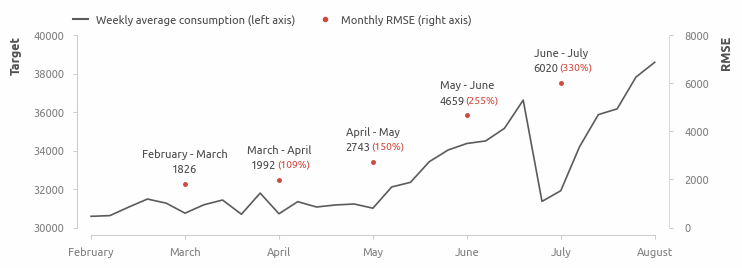

Images 'cv_rmse_plot.png' and 'cv_rmse_plot.svg' successfully saved into 'docs/img/' directory


In [115]:
fig, ax1 = plt.subplots()

# ax1.plot(train_by_week['xticks'], train_by_week['target'])
ax1.plot(train_by_week['target'].values)
ax1.set_xticks([0, 5, 10, 15, 20 , 25, 30], months_list[1:8])
ax1.set_ylabel('Target')
axis_rstyle(
    offset_left=-10, offset_bottom=5, ax=ax1)

ax2 = ax1.twinx()
ax2.scatter(
    x=[5, 10, 15, 20 , 25],
    y=cv1_results_df[cv1_results_best_model],
    # color=saturate_color(palette[1], 1.5),
    color=palette_bright[1],
    s=25)
months_rmse_names = [
    'February - March', 'March - April', 'April - May', 'May - June', 'June - July'
]
for i, j, k, v in zip(
    [5, 10, 15, 20 , 25],
    cv1_results_df[cv1_results_best_model],
    months_rmse_names,
    cv1_results_best_model_pct_change.index):
        if v > 0:
            delta_v = \
                cv1_results_best_model_pct_change.values[v]
            value_text = f'{int(round(j, 0))}'
            value_delta_text = f'({round(delta_v)}%)'
            
            ax2.text(s=value_text, x=i-0.8, y=j+450,
                 size=8, ha='center', color='#4B4B4B')
            ax2.text(s=value_delta_text, x=i+0.8, y=j+475,
                 size=7.5, ha='center', color=palette_bright[1])
        else:
            value_text = f'{int(round(j, 0))}'
            ax2.text(s=value_text, x=i, y=j+450,
                 size=8, ha='center', color='#4B4B4B')
            
        ax2.annotate(text=k, xy=(i, j+1100),
                     size=8, ha='center')

ax2.set_ylim(0, 8000)
ax2.grid(False)
ax2.spines['right'].set_visible(True)
ax2.spines[['left', 'bottom']].set_visible(False)
# ax2.spines['right'].set_bounds(0, 0.25)
ax2.spines['right'].set_position(('outward', -10))
ax2.spines['right'].set_color('#CCCCCC')
ax2.set_yticks(arange(0, 8001, 2000))
ax2.set_ylabel('RMSE')
ax2.tick_params(axis='y', direction='out', color='#CECECE', size=3)
ax2.tick_params(labelcolor='#808080')

plt.legend(
    **legend_inline(),
    **legend_create_handles(
        2, ['l', 'p'],
        labels=['Weekly average consumption (left axis)', 'Monthly RMSE (right axis)'],
        colors=[palette[0], palette_bright[1]],
    )
)
plt.show()

savefig('cv_rmse_plot', dir_save_img)

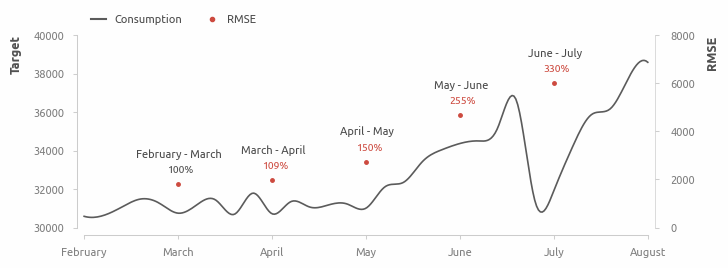

Images 'cv_rmse_plot.png' and 'cv_rmse_plot.svg' successfully saved into 'docs/img/' directory


In [116]:
fig, ax1 = plt.subplots()

# ax1.plot(train_by_week['xticks'], train_by_week['target'])
ax1.plot(smoothed(train_by_week['target'].values, k=3))
ax1.set_xticks([0, 5, 10, 15, 20 , 25, 30], months_list[1:8])
ax1.set_ylabel('Target')
axis_rstyle(
    offset_left=-15, offset_bottom=5, ax=ax1)

ax2 = ax1.twinx()
ax2.scatter(
    x=[5, 10, 15, 20 , 25],
    y=cv1_results_df[cv1_results_best_model],
    # color=saturate_color(palette[1], 1.5),
    color=palette_bright[1],
    s=25)
months_rmse_names = [
    'February - March', 'March - April', 'April - May', 'May - June', 'June - July'
]
for i, j, k, v in zip(
    [5, 10, 15, 20 , 25],
    cv1_results_df[cv1_results_best_model],
    months_rmse_names,
    cv1_results_best_model_pct_change.index):
        if v > 0:
            delta_v = \
                cv1_results_best_model_pct_change.values[v]
            value_text = f'{int(round(j, 0))}'
            value_delta_text = f'{round(delta_v)}%'
            
            # ax2.text(s=value_text, x=i-0.8, y=j+450,
            #      size=8, ha='center', color='#4B4B4B')
            ax2.text(s=value_delta_text, x=i+0.15, y=j+475,
                 size=7.5, ha='center', color=palette_bright[1])
        else:
            # value_text = f'{int(round(j, 0))}'
            # ax2.text(s=value_text, x=i, y=j+450,
            #      size=8, ha='center', color='#4B4B4B')
            value_text = '100%'
            ax2.text(s=value_text, x=i+0.1, y=j+450,
                 size=7.5, ha='center', color='#4B4B4B')
            
        ax2.annotate(text=k, xy=(i+0.05, j+1100),
                     size=8, ha='center')

ax2.set_ylim(0, 8000)
ax2.grid(False)
ax2.spines['right'].set_visible(True)
ax2.spines[['left', 'bottom']].set_visible(False)
# ax2.spines['right'].set_bounds(0, 0.25)
ax2.spines['right'].set_position(('outward', -15))
ax2.spines['right'].set_color('#CCCCCC')
ax2.set_yticks(arange(0, 8001, 2000))
ax2.set_ylabel('RMSE')
ax2.tick_params(axis='y', direction='out', color='#CECECE', size=3)
ax2.tick_params(labelcolor='#808080')

plt.legend(
    **legend_inline(bbox_to_anchor=(0.04, 1)),
    **legend_create_handles(
        2, ['l', 'p'],
        labels=['Consumption', 'RMSE'],
        colors=[palette[0], palette_bright[1]],
    )
)
plt.show()

savefig('cv_rmse_plot', dir_save_img)

## Validation Forecast : Base Model

In [117]:
cv1_results_best_model

'ARIMA (2, 1, 1) (144,) (4,)'

In [118]:
order = cv1_results_best_model_order
fourier_period = cv1_results_best_model_f_period
fourier_order = cv1_results_best_model_f_order

In [119]:
print(order, fourier_period, fourier_order)

(2, 1, 1) [144] [4]


#### August forecast

In [120]:
train_data = train.loc['2017-07', target]
valid_data = valid.loc[:, target]

train_features = train.loc['2017-07', features]
valid_features = valid.loc[:, features]

In [121]:
train_exogs, valid_exogs = \
    datasets_w_fourier(
        fourier_period=fourier_period,
        fourier_order=fourier_order,
        train_data=train_data,
        eval_data=valid_data,
        train_exog=train_features,
        eval_exog=valid_features)

In [122]:
train_data

2017-07-01 00:00:00    36384.31894
2017-07-01 00:10:00    35689.03654
2017-07-01 00:20:00    34751.36213
2017-07-01 00:30:00    33954.01993
2017-07-01 00:40:00    33411.82724
                          ...     
2017-07-31 23:10:00    43407.30897
2017-07-31 23:20:00    42507.90698
2017-07-31 23:30:00    41659.53488
2017-07-31 23:40:00    40843.05648
2017-07-31 23:50:00    39631.09635
Freq: 10min, Name: target, Length: 4464, dtype: float64

In [123]:
train_exogs.head()

,"sin(1,144)","cos(1,144)","sin(2,144)","cos(2,144)","sin(3,144)","cos(3,144)","sin(4,144)","cos(4,144)",is_Friday,is_Sunday,is_31,target_previous_month
2017-07-01 00:00:00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0,0,0,38145.69536
2017-07-01 00:10:00,0.043619,0.999048,0.087156,0.996195,0.130526,0.991445,0.173648,0.984808,0,0,0,37827.81457
2017-07-01 00:20:00,0.087156,0.996195,0.173648,0.984808,0.258819,0.965926,0.342020,0.939693,0,0,0,36200.26490
2017-07-01 00:30:00,0.130526,0.991445,0.258819,0.965926,0.382683,0.923880,0.500000,0.866025,0,0,0,34966.88742
2017-07-01 00:40:00,0.173648,0.984808,0.342020,0.939693,0.500000,0.866025,0.642788,0.766044,0,0,0,34699.86755


In [124]:
valid_data

2017-08-01 00:00:00    38517.20311
2017-08-01 00:10:00    37973.80688
2017-08-01 00:20:00    37308.94562
2017-08-01 00:30:00    36164.61709
2017-08-01 00:40:00    35678.75694
                          ...     
2017-08-31 23:10:00    38619.48946
2017-08-31 23:20:00    38370.16648
2017-08-31 23:30:00    37724.48391
2017-08-31 23:40:00    36874.22863
2017-08-31 23:50:00    36215.76027
Freq: 10min, Name: target, Length: 4464, dtype: float64

In [125]:
valid_exogs.head()

,"sin(1,144)","cos(1,144)","sin(2,144)","cos(2,144)","sin(3,144)","cos(3,144)","sin(4,144)","cos(4,144)",is_Friday,is_Sunday,is_31,target_previous_month
2017-08-01 00:00:00,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0,0,0,36384.31894
2017-08-01 00:10:00,0.043619,0.999048,0.087156,0.996195,0.130526,0.991445,0.173648,0.984808,0,0,0,35689.03654
2017-08-01 00:20:00,0.087156,0.996195,0.173648,0.984808,0.258819,0.965926,0.342020,0.939693,0,0,0,34751.36213
2017-08-01 00:30:00,0.130526,0.991445,0.258819,0.965926,0.382683,0.923880,0.500000,0.866025,0,0,0,33954.01993
2017-08-01 00:40:00,0.173648,0.984808,0.342020,0.939693,0.500000,0.866025,0.642788,0.766044,0,0,0,33411.82724


In [126]:
model = SARIMAX(
    endog=train_data,
    exog=train_exogs,
    order=order,
    seasonal_order=(0, 0, 0, 0),
).fit(maxiter=1000, disp=False)

In [127]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                 4464
Model:               SARIMAX(2, 1, 1)   Log Likelihood              -33231.198
Date:                Fri, 17 May 2024   AIC                          66494.395
Time:                        11:01:14   BIC                          66596.853
Sample:                    07-01-2017   HQIC                         66530.512
                         - 07-31-2017                                         
Covariance Type:                  opg                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
sin(1,144)            -7549.9508    171.761    -43.956      0.000   -7886.597   -7213.305
cos(1,144)              682.5194    143.072      4.770      0.000     402.103     962.936
sin(2,14

In [128]:
forecast = model.get_forecast(steps=len(valid_data), exog=valid_exogs)

In [129]:
y_pred = forecast.predicted_mean

In [130]:
y_true = valid_data

##### R-squared

In [131]:
round(r2_score(y_true, y_pred), 3)

0.893

###### MAE

In [132]:
round(mean_absolute_error(y_true, y_pred))

1778

###### RMSE

In [133]:
round(root_mean_squared_error(y_true, y_pred))

2307

###### MAPE

In [134]:
round(mean_absolute_percentage_error(y_true, y_pred) * 100, 2)

5.14

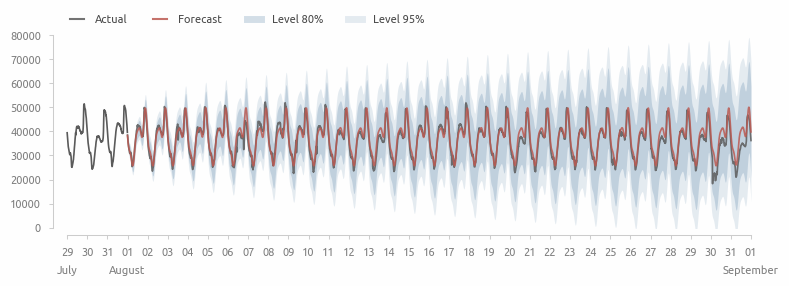

Images 'forecast_august_plot.png' and 'forecast_august_plot.svg' successfully saved into 'docs/img/' directory


In [135]:
fig = plt.figure(figsize=(9, 2.5))
ax=ax_current()

plt.plot(train.loc['2017-07-29':, target], color=palette[0])

plot_forecast(
    y_true, y_pred, forecast, ci=[80, 95],
    alpha_actual=0.85, alpha_forecast=0.85,
    palette=[palette[0], palette[1], palette[2]])

ax.set_xticks(
    ticks=pd.date_range(start='2017-07-29', end='2017-09-01', freq='1d'))
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%d'))

ax2 = axis_secondary(pad=27)
ax2.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%B'))
ax2.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=[7], bymonthday=29))

ax3 = axis_secondary(pad=27)
ax3.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%B'))
ax3.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=[8]))

ax4 = axis_secondary(pad=27)
ax4.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%B'))
ax4.xaxis.set_major_locator(mpl.dates.MonthLocator(bymonth=[9]))

axis_rstyle(
    offset_left=5, offset_bottom=5,
    ylim=[0, 80000], yticks=[0, 80000, 10000])
# plt.ylabel('Target')
plt.show()

savefig('forecast_august_plot', dir_save_img)

## Residuals research

In [136]:
resid =  y_pred - y_true

In [137]:
test_normality(resid)

,Test,P or Statistic (s),Condition
0,Kolmogorov-Smirnov,0.0000,Not normal
1,Anderson-Darling (s),12.4603,Not normal
2,Shapiro-Wilk,0.0000,Not normal
3,Jarque-Bera,0.0000,Not normal
4,D’Agostino-Pearson,0.0000,Not normal


In [138]:
np.std(resid)

2110.602768310476

In [139]:
len(resid)

4464

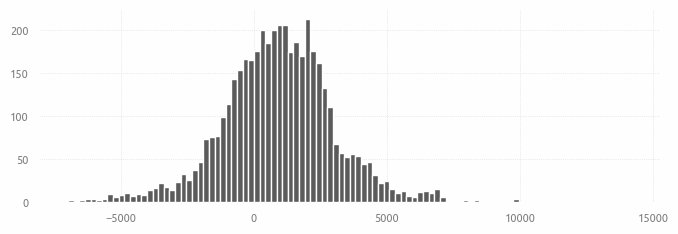

In [140]:
plt.hist(resid, bins=100);

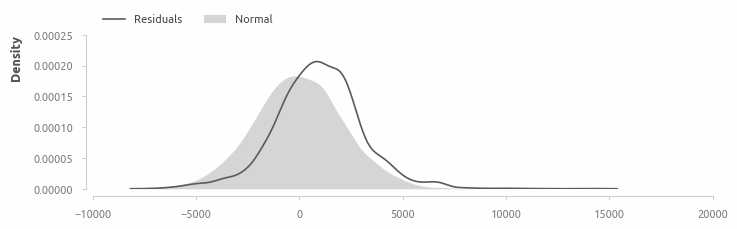

Images 'residuals_distribution_plot.png' and 'residuals_distribution_plot.svg' successfully saved into 'docs/img/' directory


In [141]:
fig = plt.figure(figsize=(8, 2))

sns.kdeplot(resid, color=palette[0], label='Residuals');
sns.kdeplot(
    np.random.normal(0, np.std(resid), len(resid)),
    color=palette[0], fill=True, lw=0.01, label='Normal');
axis_rstyle(offset_left=5, offset_bottom=5)

plt.legend(**legend_inline())
plt.show()

savefig('residuals_distribution_plot', dir_save_img)

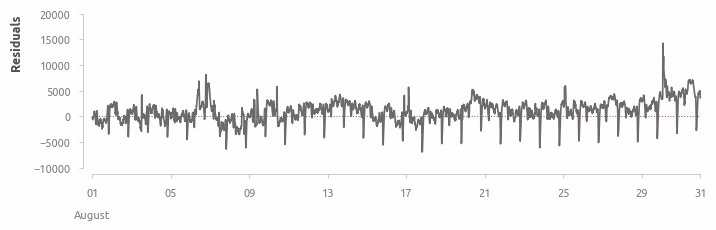

Images 'residuals_plot.png' and 'residuals_plot.svg' successfully saved into 'docs/img/' directory


In [142]:
fig = plt.figure(figsize=(8, 2))
ax = ax_current()

plt.plot(resid, color=alpha_color(palette[0], 0.9), zorder=10);
plot_zeroline(lw=0.75, color=palette[1], zorder=1)
axis_formatter_locator(mpl.dates.DateFormatter('%d'))
ax2 = axis_secondary(pad=30)
axis_formatter_locator(mpl.dates.DateFormatter('%B'), mpl.dates.MonthLocator(8), ax=ax2)
plt.ylabel('Residuals')
axis_rstyle(offset_bottom=5, offset_left=2.5)
ticklabels_f_modify(-1, '31')
plt.show()

savefig('residuals_plot', dir_save_img)

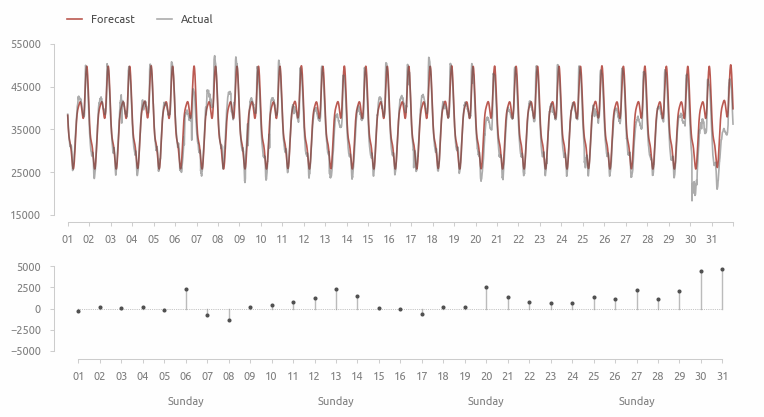

Images 'forecast_august_resid_mean_plot.png' and 'forecast_august_resid_mean_plot.svg' successfully saved into 'docs/img/' directory


In [143]:
resid_mean = resid.groupby(resid.index.floor('D')).mean()

fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(y_pred.index, y_pred, color=palette[1], label='Forecast')
ax[0].plot(y_true.index, y_true, color=palette[0], alpha=0.5, label='Actual')

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%d'))
ax[0].xaxis.set_major_locator(mpl.dates.DayLocator())

ax[0].set_xlim(y_pred.index[0]-dt.timedelta(days=0.5), y_pred.index[-1]+dt.timedelta(days=1))
# ax[0].set_ylabel('Target')
axis_rstyle(offset_left=2.5, offset_bottom=5, yticks=[15000, 55000, 10000], ax=ax[0])
ax[0].legend(**legend_inline(bbox_to_anchor=(0, 1.05)), handlelength=1.35)
ticklabels_f_remove(-1, ax[0])

for i in resid_mean.index:
    ax[1].plot([i, i], [0, resid_mean[i]], color=palette[-1], lw=1)
    ax[1].scatter(i, resid_mean[i], s=15, color=palette[-4], zorder=10)

ax[1].plot(
    [resid_mean.index[0], resid_mean.index[-1]],
    [0, 0],
    lw=0.5, ls=':', color=palette[-2])

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%d'))
ax[1].xaxis.set_major_locator(mpl.dates.DayLocator())
ax1_axis_sec =  ax[1].secondary_xaxis('bottom')
ax1_axis_sec.spines['bottom'].set_visible(False)
ax1_axis_sec.tick_params(pad=32, bottom=False, colors='#808080')
ax1_axis_sec.xaxis.set_major_locator(mpl.dates.WeekdayLocator(mpl.dates.SU))
ax1_axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))

ax[1].set_xlim(y_pred.index[0]-dt.timedelta(days=1), y_pred.index[-1]+dt.timedelta(days=0.5))
# ax[1].set_ylabel('Resid. mean')

axis_rstyle(
    offset_left=2.5, xslice=[1, -1], yticks=[-5000, 5000, 2500],
    ylim=[-5100, 5000], ax=ax[1])

plt.subplots_adjust(hspace=0.4)
plt.show()

savefig('forecast_august_resid_mean_plot', dir_save_img)

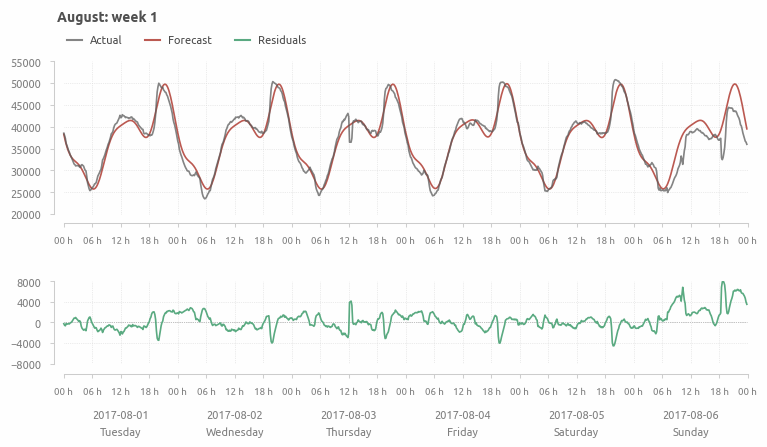

In [144]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-01':'2017-08-06'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-01':'2017-08-06'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(
    **legend_inline(),
    **legend_create_handles(
        3, kind='l',
        labels=['Actual', 'Forecast', 'Residuals'],
        colors=[palette[0], palette[1], palette[3]],
        alphas=[0.75, 1, 0.9]))

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
# axis_sec = ax[0].secondary_xaxis('bottom')
# axis_sec.spines['bottom'].set_visible(False)
# axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
# axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
# axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(
    offset_bottom=2.5, offset_left=2.5,
    ax=ax[0], xslice=[1, -1], grid=True)

ax[1].plot(resid.loc['2017-08-01':'2017-08-06'], color=alpha_color(palette[3], 0.9))
ax[1].axhline(0, 0.01, 0.99, lw=0.5, ls=':', zorder=-1)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=33, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=45)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(
    offset_bottom=7.5, offset_left=2.5,
    yticks=[-8000, 8000, 4000], ylim=[-8000, 8000],
    xslice=[1, -1], ax=ax[1], grid=True)

plt.subplots_adjust(hspace=0.5)
ax[0].set_title('August: week 1', **title_inline)
plt.show()

# savefig('forecast_august_detail_plot_week1', dir_save_img)

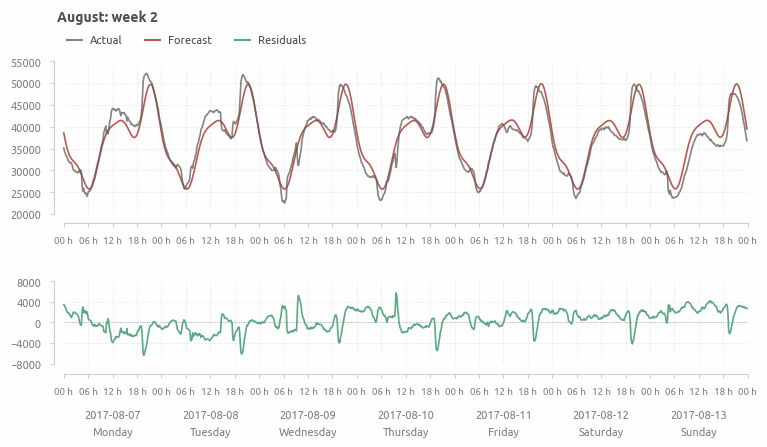

In [145]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-07':'2017-08-13'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-07':'2017-08-13'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(
    **legend_inline(),
    **legend_create_handles(
        3, kind='l',
        labels=['Actual', 'Forecast', 'Residuals'],
        colors=[palette[0], palette[1], palette[3]],
        alphas=[0.75, 1, 0.9]))

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
# axis_sec = ax[0].secondary_xaxis('bottom')
# axis_sec.spines['bottom'].set_visible(False)
# axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
# axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
# axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(
    offset_bottom=2.5, offset_left=2.5,
    ax=ax[0], xslice=[1, -1], grid=True)

ax[1].plot(resid.loc['2017-08-07':'2017-08-13'], color=alpha_color(palette[3], 0.9))
ax[1].axhline(0, 0.01, 0.99, lw=0.5, ls=':', zorder=-1)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=33, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=45)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(
    offset_bottom=7.5, offset_left=2.5,
    yticks=[-8000, 8000, 4000], ylim=[-8000, 8000],
    xslice=[1, -1], ax=ax[1], grid=True)

plt.subplots_adjust(hspace=0.5)
ax[0].set_title('August: week 2', **title_inline)
plt.show()

# savefig('forecast_august_detail_plot_week2', dir_save_img)

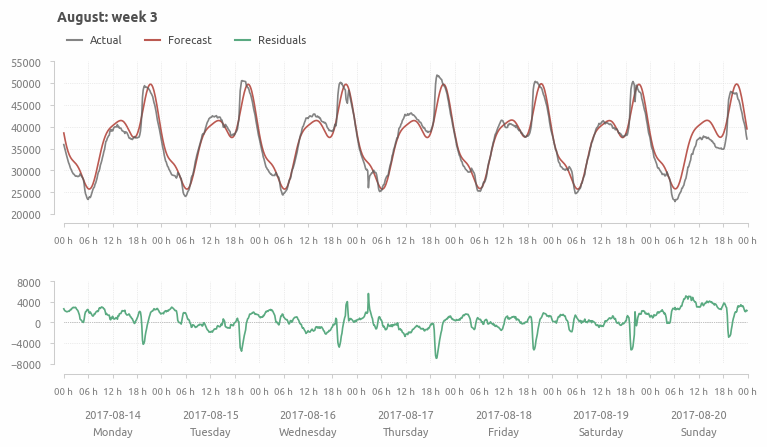

In [146]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-14':'2017-08-20'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-14':'2017-08-20'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(
    **legend_inline(),
    **legend_create_handles(
        3, kind='l',
        labels=['Actual', 'Forecast', 'Residuals'],
        colors=[palette[0], palette[1], palette[3]],
        alphas=[0.75, 1, 0.9]))

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
# axis_sec = ax[0].secondary_xaxis('bottom')
# axis_sec.spines['bottom'].set_visible(False)
# axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
# axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
# axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(
    offset_bottom=2.5, offset_left=2.5,
    ax=ax[0], xslice=[1, -1], grid=True)

ax[1].plot(resid.loc['2017-08-14':'2017-08-20'], color=alpha_color(palette[3], 0.9))
ax[1].axhline(0, 0.01, 0.99, lw=0.5, ls=':', zorder=-1)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=33, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=45)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(
    offset_bottom=7.5, offset_left=2.5,
    yticks=[-8000, 8000, 4000], ylim=[-8000, 8000],
    xslice=[1, -1], ax=ax[1], grid=True)

plt.subplots_adjust(hspace=0.5)
ax[0].set_title('August: week 3', **title_inline)
plt.show()

# savefig('forecast_august_detail_plot_week3', dir_save_img)

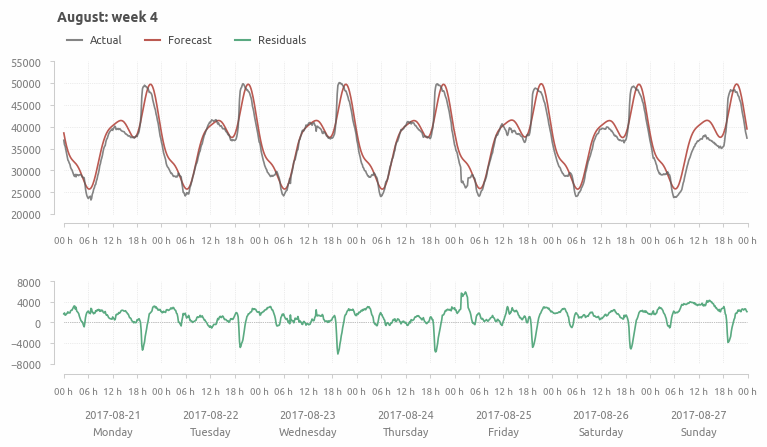

In [147]:
fig, ax = plt.subplots(2, 1, figsize=(9, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-21':'2017-08-27'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-21':'2017-08-27'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(
    **legend_inline(),
    **legend_create_handles(
        3, kind='l',
        labels=['Actual', 'Forecast', 'Residuals'],
        colors=[palette[0], palette[1], palette[3]],
        alphas=[0.75, 1, 0.9]))

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
# axis_sec = ax[0].secondary_xaxis('bottom')
# axis_sec.spines['bottom'].set_visible(False)
# axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
# axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
# axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(
    offset_bottom=2.5, offset_left=2.5,
    ax=ax[0], xslice=[1, -1], grid=True)

ax[1].plot(resid.loc['2017-08-21':'2017-08-27'], color=alpha_color(palette[3], 0.9))
ax[1].axhline(0, 0.01, 0.99, lw=0.5, ls=':', zorder=-1)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=33, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=45)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(
    offset_bottom=7.5, offset_left=2.5,
    yticks=[-8000, 8000, 4000], ylim=[-8000, 8000],
    xslice=[1, -1], ax=ax[1], grid=True)

plt.subplots_adjust(hspace=0.5)
ax[0].set_title('August: week 4', **title_inline)
plt.show()

# savefig('forecast_august_detail_plot_week4', dir_save_img)

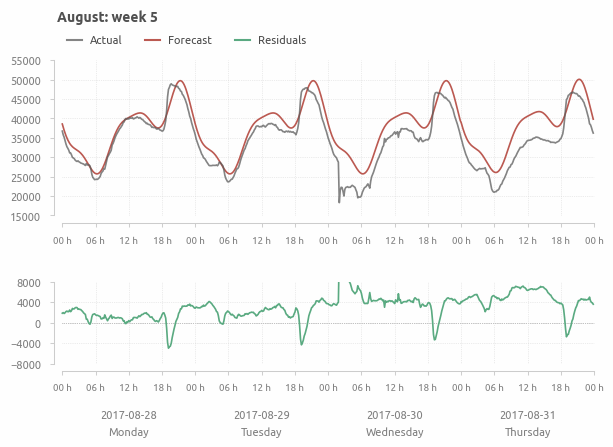

In [148]:
fig, ax = plt.subplots(2, 1, figsize=(7, 4), height_ratios=[2, 1])

ax[0].plot(
    y_pred.loc['2017-08-28':'2017-08-31'],
    color=palette[1], label='Forecast')
ax[0].plot(
    y_true.loc['2017-08-28':'2017-08-31'],
    color=palette[0], alpha=0.75, label='Actual')

ax[0].legend(
    **legend_inline(),
    **legend_create_handles(
        3, kind='l',
        labels=['Actual', 'Forecast', 'Residuals'],
        colors=[palette[0], palette[1], palette[3]],
        alphas=[0.75, 1, 0.9]))

ax[0].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[0].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[0].tick_params(axis='x', which='minor', labelsize=7)
ax[0].tick_params(axis='x', which='major', pad=15, labelsize=7)
# axis_sec = ax[0].secondary_xaxis('bottom')
# axis_sec.spines['bottom'].set_visible(False)
# axis_sec.tick_params(pad=30, bottom=False, colors='#808080')
# axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
# axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(
    offset_bottom=2.5, offset_left=2.5,
    ax=ax[0], grid=True)

ax[1].plot(resid.loc['2017-08-28':'2017-08-31'], color=alpha_color(palette[3], 0.9))
ax[1].axhline(0, 0.01, 0.99, lw=0.5, ls=':', zorder=-1)

ax[1].xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%H h'))
ax[1].xaxis.set_major_locator(mpl.dates.HourLocator(byhour=[0, 6, 12, 18]))
ax[1].tick_params(axis='x', which='minor', labelsize=7)
ax[1].tick_params(axis='x', which='major', pad=15, labelsize=7)
axis_sec =  ax[1].secondary_xaxis('bottom')
axis_sec.spines['bottom'].set_visible(False)
axis_sec.tick_params(pad=33, bottom=False, colors='#808080')
axis_sec.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%Y-%m-%d'))
axis_sec.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_th = axis_secondary(ax=ax[1], pad=45)
axis_th.xaxis.set_major_formatter(mpl.dates.DateFormatter(fmt='%A'))
axis_th.xaxis.set_major_locator(mpl.dates.HourLocator(byhour=12))
axis_rstyle(
    offset_bottom=5, offset_left=2.5,
    yticks=[-8000, 8000, 4000], ylim=[-8000, 8000],
    ax=ax[1], grid=True)

plt.subplots_adjust(hspace=0.5)
ax[0].set_title('August: week 5', **title_inline)
plt.show()

# savefig('forecast_august_detail_plot_week5', dir_save_img)

## Save Data

In [149]:
variables['target'] = target
variables['features'] = features
variables['order'] = (2, 1, 1)
variables['fourier_period'] = [144]
variables['fourier_order'] = [4]
variables['cv_indexes_train'] = cv_indexes_train
variables['cv_indexes_eval'] = cv_indexes_eval

In [150]:
saveit(variables, 'variables', dir_save_files)

File 'variables.pkl' saved in directory 'files/'


In [151]:
cv['cv0'] = cv0_results_dict
cv['cv1'] = cv1_results_dict
cv['cv2'] = cv2_results_dict
cv['cv3'] = cv3_results_dict

In [152]:
saveit(cv, 'cv', dir_save_files)

File 'cv.pkl' saved in directory 'files/'


### Execution time

In [153]:
stopwatch_stop(start)

Execution time: 0:01:22
